# CHALLENGE DATA ENEDIS
Challenge context

About Enedis

ENEDIS is the main distribution system operator in France (95% of continental France, 36 million customers).

The electricity market requires that production and consumption be assigned to an upstream-downstream balance operator, each electricity provider having at least one. These balance operators guarantee that supply and demand are balanced every half-hour 24/7.

In order to assign energy, Enedis computes the electricity consumption balance every week for each balance operator. Part of the balancing computation involves some consumption or production modelling for several groups of customers (aka profiles). Since July 1st 2018, we started using “dynamic” profiles in this process, computed with measured energy. These dynamic profiles bring additional precision but can only be calculated ex-post.

Being able to forecast these values is very important since:

    They would bring robustness to our process.

    Energy planning is of utmost importance to balance operators, who have to guarantee energy supply beforehand and are held responsible for any unbalance in their portfolio.

Challenge goals

We would like to forecast 7 dynamic profile time-series, modelling the consumption shape of several mass-market customer groups (residential and small businesses with subscribed power up to 36 kVA) thanks to meteorological and calendar data, as well as any other real time dataset potentially correlated with consumption patterns. Those profiles are coefficients (without units) for each half-hour in the dataset.

The dataset size depends on each specific profile (collected from Oct 13th, 2013 onwards for residential profiles and from Nov 1st, 2016 for commercial profiles). This challenge is about forecasting dynamic profiles values from their past values and all the components of Enedis’ Half hourly Electrical Balancing.

The Testing period will be in the past, from July 1st, 2017 to June 30th, 2018.

There are many possible explanatory variables since consumption patterns are linked to consumers’ behavior and economic activity. Weather conditions (cold spell / heat wave) and business holidays will impact energy consumption but some other factors may also contribute to modifying energy consumption. As an example, our RES1 profile is presented there, over a week period:
In green: static series including business holidays. In blue: static series including business holidays and weather. In red: dynamic series computed ex-post.

Presentation of the challenge at the Collège de France

You can find the presentation of the challenge made at the Collège de France here (video in French)
Data description

Edit - 2019/03/22

Please be careful to the temporal alignment: For the same ID, there is a one day delay between data provided in the input files (that are measured or estimated for the date given in Horodate_UTC ) and the values of dynamic Profiles provided in the output files (representing customer behaviour for the date given in horodate). This delay allows to have a challenge closer to our operational needs: we will be able to get the data from the input files of the previous day to forecast the dynamic profiles.

Data in the time series are hour beginning: for example, a value at à 08h00 is the integrated value from 08h00 to 08h30 for the said data.
Training files include data for the period [13/10/2013 - 12/10/2018] excluding the [01/07/2017 - 30/06/2018] period.
Regarding the 3 commercial profiles, data only start on Nov 1st,2016.
Testing files include data for the [01/07/2017 - 30/06/2018] period.
Please note that we use the French date and time notation: dd/mm/YYYY HH:MM in the files.
Time series description for the input files
Weather data:

    Température réalisée lissée (°Celcius) Average recorded temperature (°C)
    Température normale lissée (°Celcius) Average standard temperature (°C)
    Pseudo rayonnement Pseudo radiation (Linear combination of recorded data from 32 official weather stations

Measured data

    Electricity exchange with other networks:
    Injection RTE (W) Average power (during the half hours) injected from RTE (transmission grid) (W)
    Refoulement RTE (W) Average power injected back into the transmission grid (W)

    Soutirage net vers autres GRD (W) Average power injected into local DSO networks (W)

    From Smart meters
    Consommation HTA télérelevée en courbe de charge (W) load curve-measured medium voltage (MV, i.e., 20 000 V in most areas) consumption (W)
    Production décentralisée télérelevée en courbe de charge (W) load curve-measured decentralized production (W)

Modelled Data:

    Pertes modélisées (W) Losses Model based on a second order polynomial, recalibrated every year. (Based on RTE gross injection until July 1st, 2018, and on net RTE injection (Power injected – Power injected back to transmission grid), net Power injected into local independent DSOs and decentralized production since that date.
    Consommation totale profilée (W) Total modelled consumption (W)
    Consommation HTA profilée (W) MV modelled consumption (W)
    Consommation PME-PMI profilée (W) SMEs and SMIs modelled consumption (W)
    Consommation professionnelle profilée (W) Small businesses modelled consumption (W)
    Consommation résidentielle profilée (W) Households modelled consumption (W)
    Production décentralisée profilée (W) Total modelled decentralized production (W)
    Production photovoltaïque profilée (W) Photovoltaic modelled production (W)
    Production autre profilée (W) Other modelled decentralized production (W) Modelling of customer consumption through static profiling until July 1st, 2018. Since then the modelling technique has changed for 7 consumption sub profiles, from static to dynamic modelling based on real measurements.

Sums (from Models and Measurements):

    Consommations totale (W) Total consumption (W)
    Production décentralisée totale (W) Total decentralized production (W)
    Production éolienne totale (W) Total wind production (W)
    Production photovoltaïque totale (W) Total Photovoltaic production (W)
    Consommation HTA totale (W) total MV consumption (W)

Time Series description for the Output Files

    RES1_BASE: Residential customer profile, subscribed power up to 6kVA, with no tariff option
    RES11_BASE: Residential customer profile, subscribed power over 6kVA, with no tariff option
    RES2_HP: Residential customer profile, with Peak Hours/Off Peak Hours tariff option, during Peak hours.
    RES2_HC: Residential customer profile, with Peak Hours/Off Peak Hours tariff option, during Off Peak hours.
    PRO1_BASE: Commercial customer profile, with no tariff option
    PRO2_HP: Commercial customer profile, with Peak Hours/Off Peak Hours tariff option, during Peak hours
    PRO2_HC: Commercial customer profile, with Peak Hours/Off Peak Hours tariff option, during Off Peak hours.


In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split



In [137]:
tick=30 # période en minute de la time série
day_ticks=2*24 # durée en ticks d'une journée

def data_slice(data,start_day,period_day=1,columns=None) :
    
# focntion permettant de découper le dataset en temps et en features
# input data : dataframe dataset
# start_day  : int numéro du jour en référence au premier jour de l'index du dataset
# period_day : nombre de jours à extraire
# columns : list contenant le noms des colonnes à extraire si vide prend toutes les colonnes

    if columns==None : 
        columns=data.columns
        
    return data.iloc[start_day*day_ticks : (start_day+period_day)*day_ticks][columns]

def data_timeplot(data,plot_per_line=5):
# focntion permettant de représenter les séries temporelles individuelles 
# pour chacune des colonnes du dataset passer en argument
# distribue les graphiques par défaut 5 par ligne
    features=data.columns
    ppl=plot_per_line
    plt.figure(figsize=(30,ppl*(len(features)-1)//ppl+ppl))
    
    for i,c in enumerate(features) :
        
        plt.subplot((len(features)-1)/ppl+1,ppl,i+1)
        ax.xaxis_date()
        plt.plot(data[c]);
        plt.xticks(rotation=90);
        plt.ylabel(c,fontsize='x-small')
       

In [88]:
# extraction at stockage des fichiers brut
X_train_brut=pd.read_csv('training_input_qFI2jug.csv',index_col=1,parse_dates=['Horodate_UTC'],dayfirst=True)
y_train_brut=pd.read_csv('training_output_uamzSZW.csv',index_col=1,parse_dates=['Horodate_UTC'],dayfirst=True)
X_test_brut=pd.read_csv('testing_input_BcjTmnd.csv',index_col=1,parse_dates=['Horodate_UTC'],dayfirst=True)


In [96]:
# sauvegarde des colonnes IDS,Horodate et Mois
X_train_2col=X_train_brut[['IDS','Horodate','Mois']]
y_train_2col=X_train_brut[['IDS','Horodate','Mois']]
X_test_2col=X_train_brut[['IDS','Horodate','Mois']]
# supressions des colonnes IDS,Horodate et Mois 
X_train=X_train_brut.drop(['IDS','Horodate','Mois'],axis=1)
y_train=y_train_brut.drop(['IDS','Horodate','Mois'],axis=1)
X_test=X_test_brut.drop(['IDS','Horodate','Mois'],axis=1)

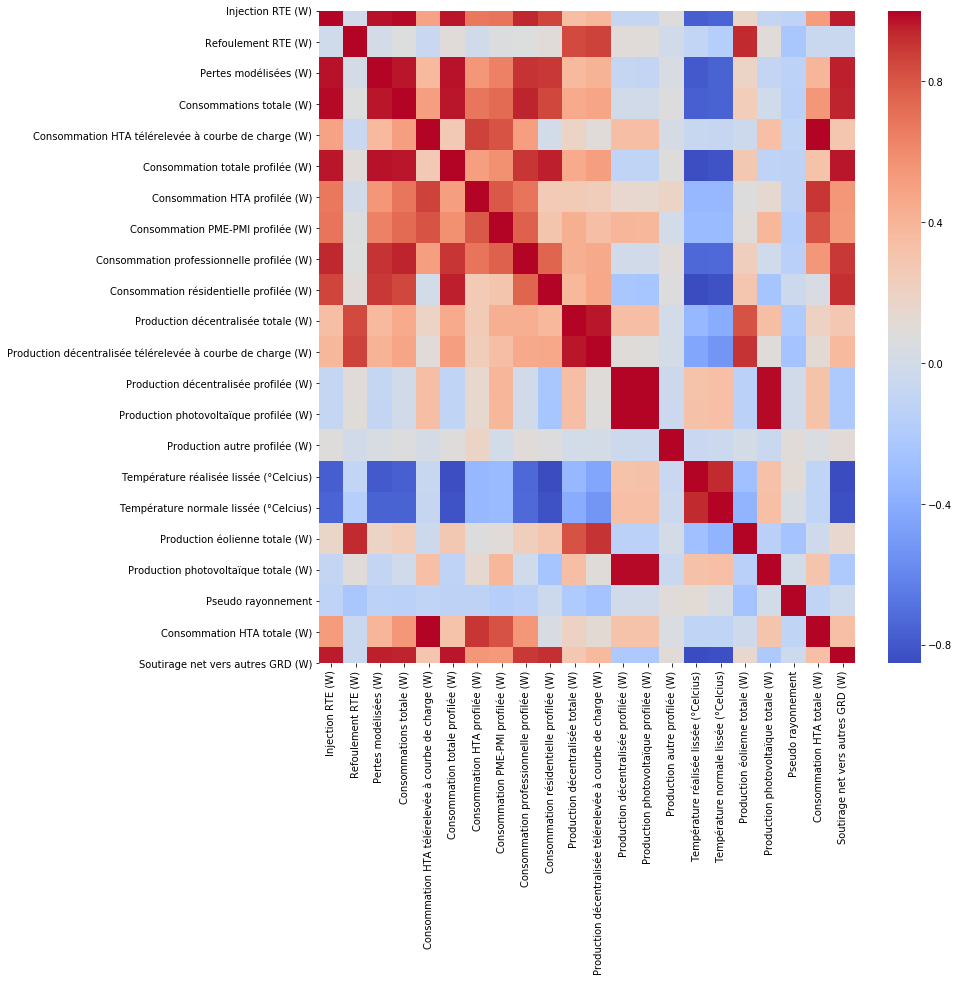

In [97]:
# visualisation pour se donner une idée de la corrélation des features
corr=X_train.corr()
fig,ax=plt.subplots(figsize=(12,12))
sns.heatmap(corr,ax=ax,cmap='coolwarm')
plt.show()

# Analyses des séries temporelles

# Snapchot données entrainement X_train sur une journée

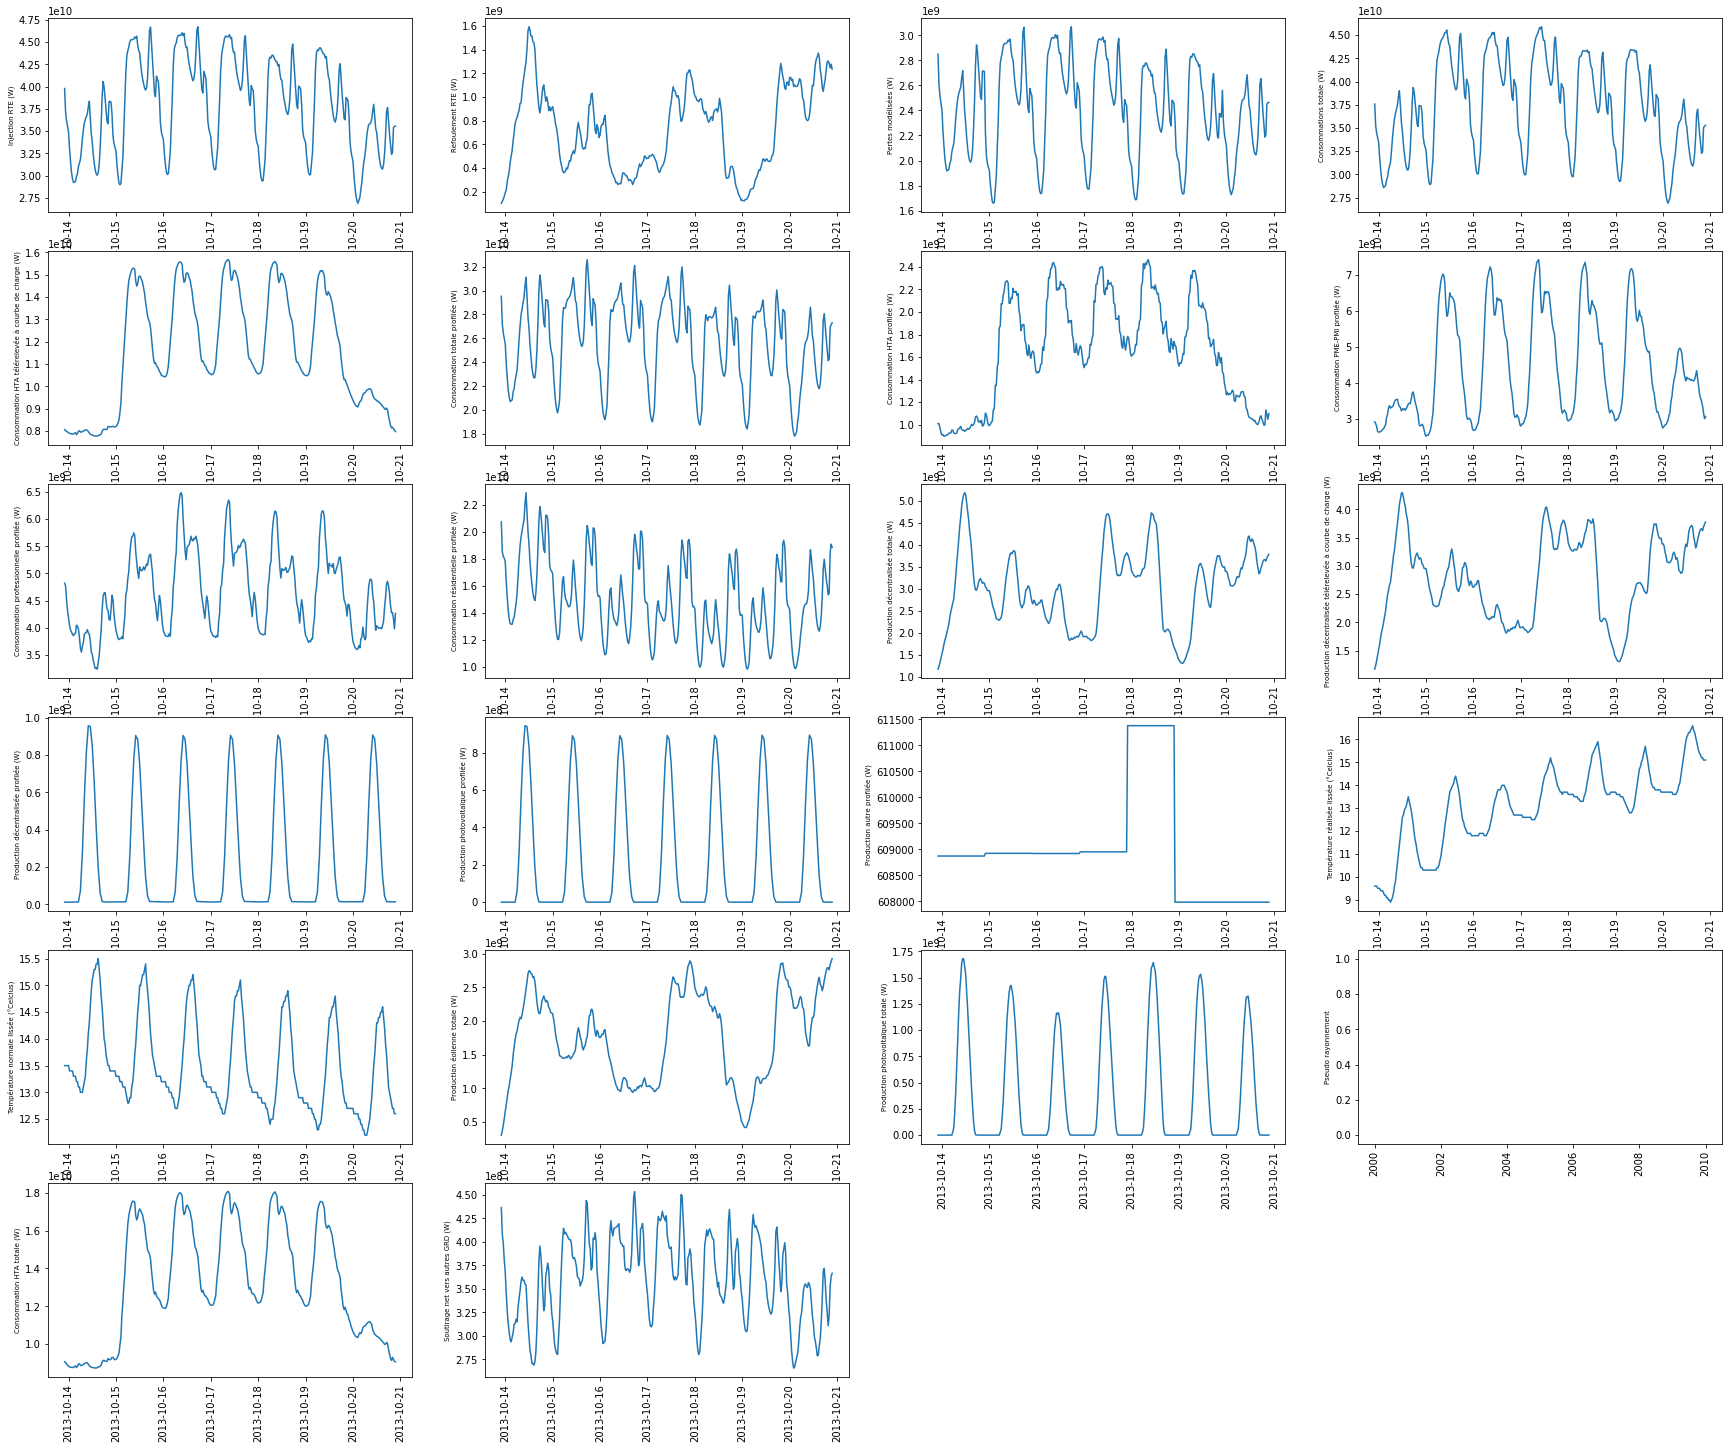

In [140]:
df_slice=data_slice(X_train,0,7)
data_timeplot(df_slice,4)


# Visualisation profile RES1_BASE

0

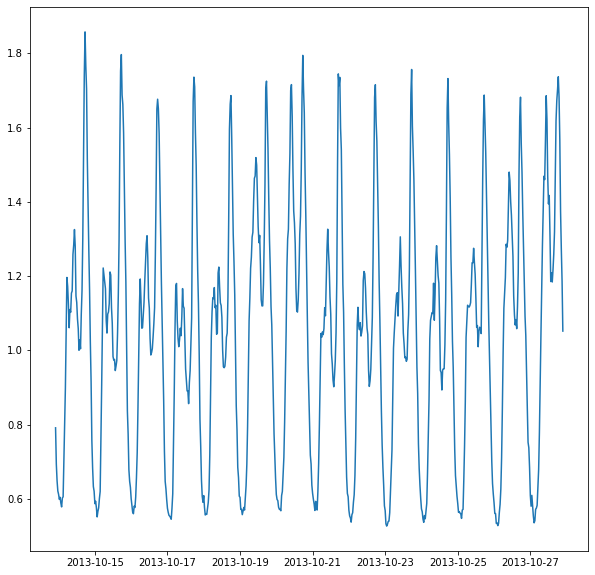

In [114]:
y_slice=data_slice(y_train,0,14,columns=['RES1_BASE'])
plt.figure(figsize=(10,10))
plt.plot(y_slice)
y_train.index[4].weekday()

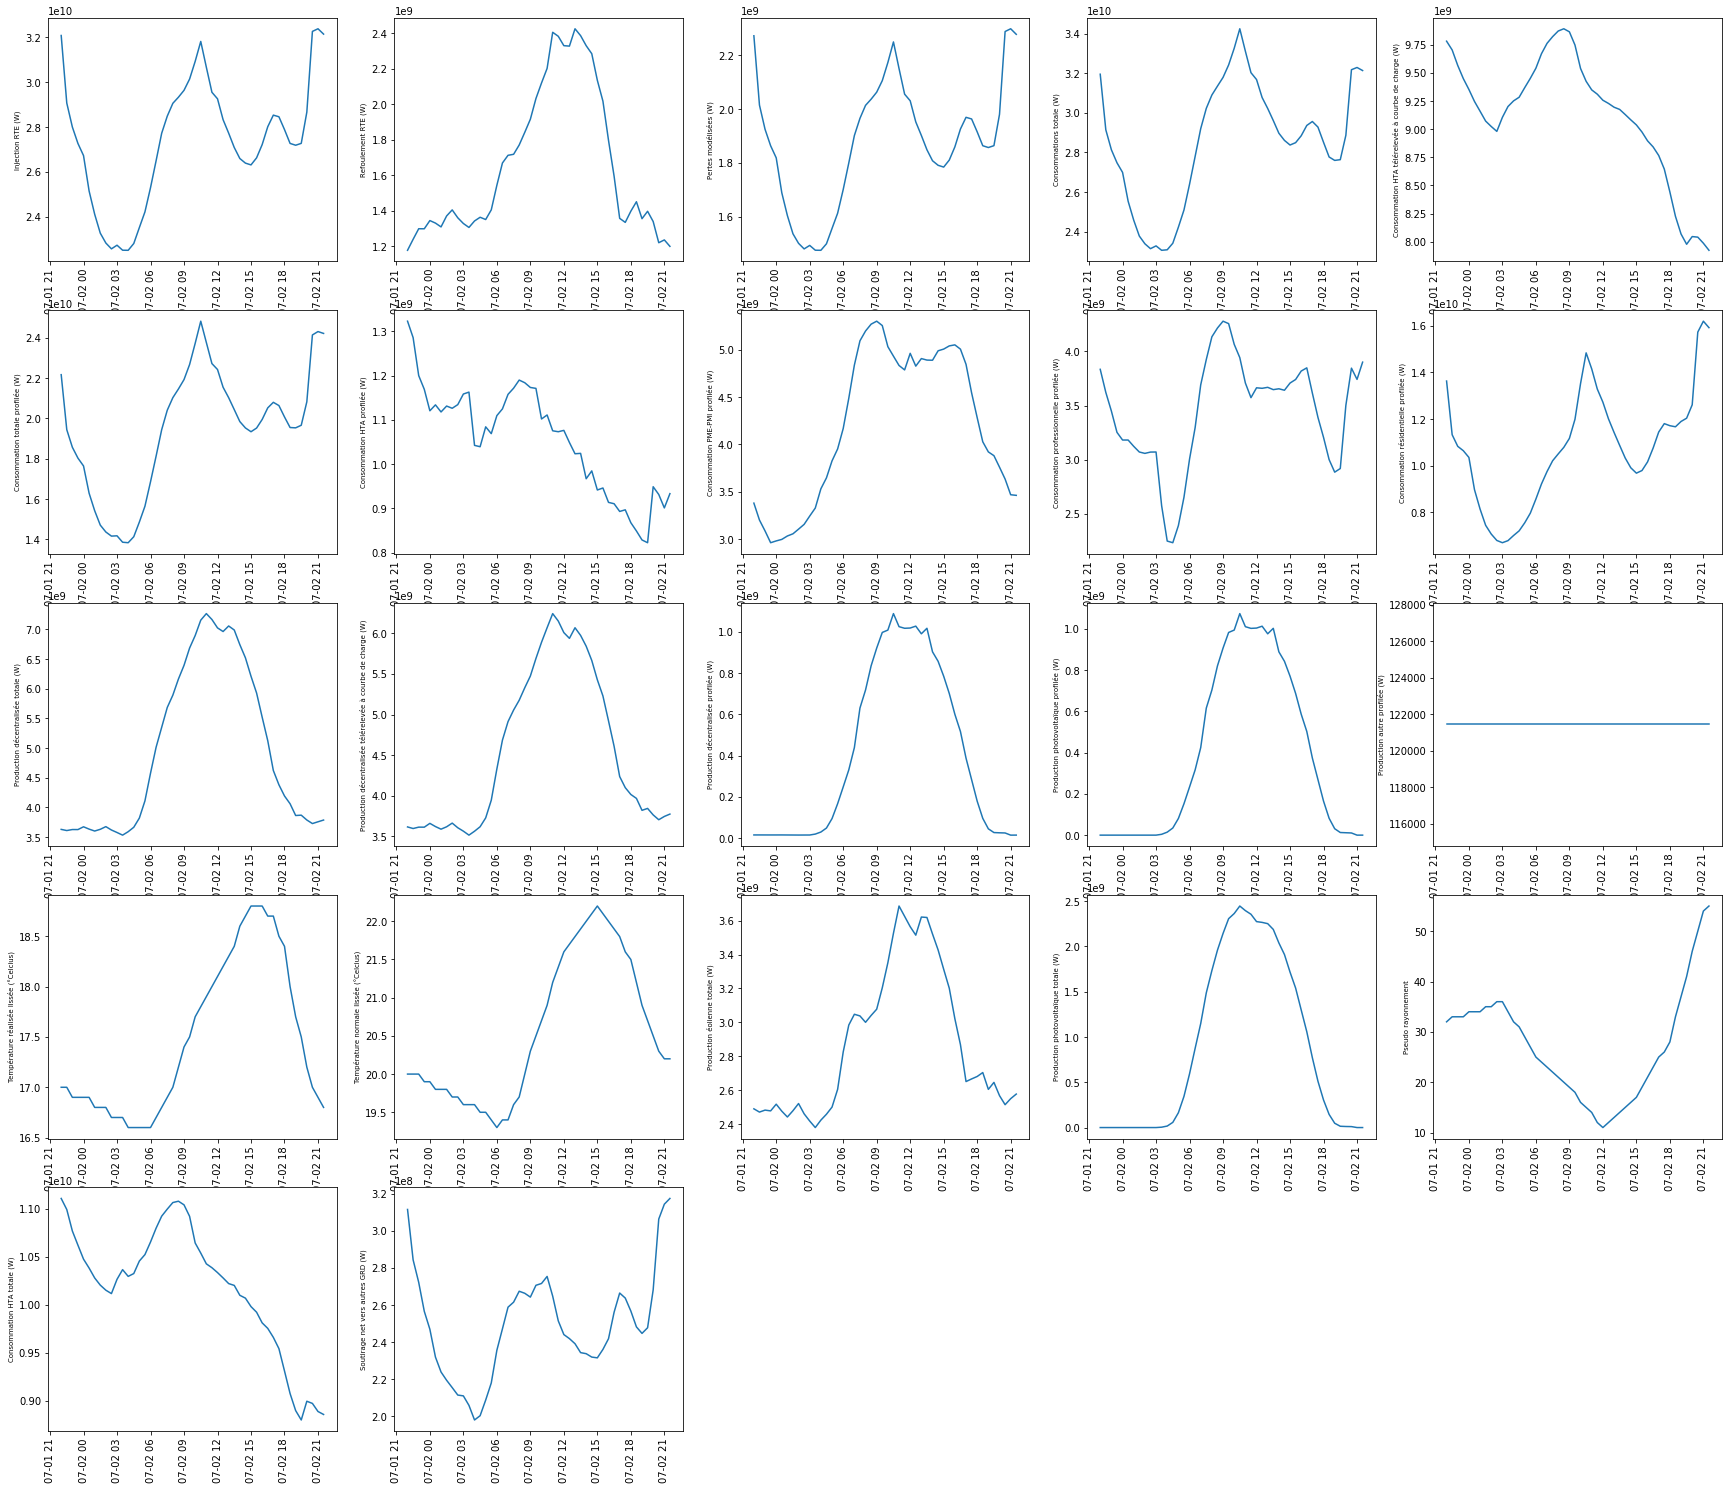

In [101]:
xtest_slice=data_slice(X_test,0)
data_timeplot(xtest_slice)